<h1>🍺Original dataset:</h1>
<a href="https://www.kaggle.com/datasets/nickhould/craft-cans">link</a> 

<h2>🚩Import libraries and do some EDA</h2>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn.linear_model import Ridge

from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

In [3]:
plt.style.use('ggplot')

In [4]:
data = pd.read_csv('beers.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2410 non-null   int64  
 1   abv         2348 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2405 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB


In [6]:
data.describe()

,Unnamed: 0,abv,ibu,id,brewery_id,ounces
count,2410.000000,2348.000000,1405.000000,2410.000000,2410.000000,2410.000000
mean,1204.500000,0.059773,42.713167,1431.113278,231.749793,13.592241
std,695.851397,0.013542,25.954066,752.459975,157.685604,2.352204
min,0.000000,0.001000,4.000000,1.000000,0.000000,8.400000
25%,602.250000,0.050000,21.000000,808.250000,93.000000,12.000000
50%,1204.500000,0.056000,35.000000,1453.500000,205.000000,12.000000
75%,1806.750000,0.067000,64.000000,2075.750000,366.000000,16.000000
max,2409.000000,0.128000,138.000000,2692.000000,557.000000,32.000000


In [7]:
data.head(5)

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


<b>Dataset fields description:</b>
<ul>
    <li>"Unnamed: 0" - row number.</li>
    <li>"abv" - The alcoholic content by volume with 0 being no alcohol and 1 being pure alcohol.</li>
    <li>"ibu" - International bittering units, which describe how bitter a drink is.</li>
    <li>"id" - Unique ID</li>
    <li>"name" - Name of the beer.</li>
    <li>"style" - Beer style (lager, ale, IPA, etc.)(Target!)</li>
    <li>"brewery_id" - Unique identifier for brewery that produces this beer; can use to join with brewery info.</li>
    <li>"ounces" - Size of beer in ounces.</li>
</ul>

✅Check NaN in data

In [8]:
data.isna().any().any()

True

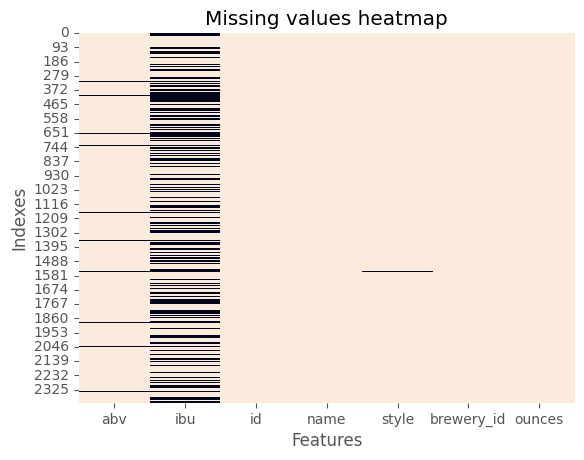

In [9]:
heatmap_data = data.copy()
heatmap_data.drop(['Unnamed: 0'], axis=1, inplace=True)
heatmap_data[~heatmap_data.isnull()] = 1
heatmap_data[heatmap_data.isnull()] = 0
heatmap_data['name'] = heatmap_data['name'].astype(int)
heatmap_data['style'] = heatmap_data['style'].astype(int)

sns.heatmap(heatmap_data, cbar=False)

plt.xlabel('Features')
plt.ylabel('Indexes')
plt.title('Missing values heatmap')
plt.show()

In [10]:
data['abv'][data['abv'].isna() == True].shape[0]

62

In [11]:
data['ibu'][data['ibu'].isna() == True].shape[0]

1005

In [12]:
data['style'][data['style'].isna() == True].shape[0]

5

✅Let's check object distribution

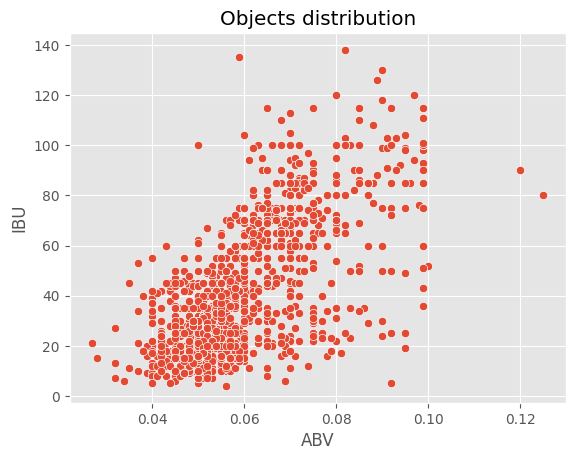

In [13]:
not_nul_indexes = data[(data['abv'].isna() == False) & (data['ibu'].isna() == False)].index
x = data['abv'].iloc[not_nul_indexes]
y = data['ibu'].iloc[not_nul_indexes]

sns.scatterplot(x=x, y=y)
plt.xlabel('ABV')
plt.ylabel('IBU')
plt.title('Objects distribution')
plt.show()

✅Let's fill missing values!

In [14]:
# Filling missing abv with median
data['abv'].fillna(data['abv'].median(), inplace=True)
# Filling missing style with "_"
data['style'].fillna('_', inplace=True)

✅Fill missing values in ibu with fitted linear model!

In [15]:
ibu_missing = data[data['ibu'].isna()].index
train_data = data[~data['ibu'].isna()].index

train_target = data.iloc[train_data]
train_target = train_target[['ibu']]
train_data = data.iloc[train_data]
train_data = train_data[['abv', 'ounces']]

X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [16]:
param_grid = {
    'alpha': [0.01, 0.1, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0, 1.5, 2.0, 2.5],
    'max_iter': [10, 100, 250, 500, 1000, 1250, 1500]
}

lin_model = GridSearchCV(Ridge(random_state=42), param_grid=param_grid, cv=15)
lin_model.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=Ridge(random_state=42),
             param_grid={'alpha': [0.01, 0.1, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0, 1.5,
                                   2.0, 2.5],
                         'max_iter': [10, 100, 250, 500, 1000, 1250, 1500]})

In [17]:
lin_model.best_estimator_

Ridge(alpha=2.5, max_iter=10, random_state=42)

In [18]:
print(metrics.mean_absolute_error(y_test, lin_model.predict(X_test)))

15.207787186874958


In [19]:
X = data.iloc[data[~data['ibu'].isna()].index]
X.drop(['id', 'name', 'style', 'brewery_id'], inplace=True, axis=1)
y = X['ibu']
X.drop(['ibu'], axis=1, inplace=True)
X = StandardScaler().fit_transform(X)

lin_model = Ridge(alpha=2.5, max_iter=10, random_state=42)
lin_model.fit(X, y)
print(metrics.mean_absolute_error(y, lin_model.predict(X)))

15.028594763064767


In [20]:
X_fill = data.iloc[ibu_missing]
X_fill.drop(['id', 'name', 'style', 'brewery_id', 'ibu'], inplace=True, axis=1)
X_fill = StandardScaler().fit_transform(X_fill)

miss_vals = lin_model.predict(X_fill)

In [21]:
for pos, index in enumerate(ibu_missing):
    data['ibu'][index] = miss_vals[pos]

In [22]:
data.isna().any().any()

False

✅Let's separate data on clusters using DBSCAN!

In [23]:
X_cl = data.drop(['Unnamed: 0', 'id', 'name', 'style', 'brewery_id'], axis=1)
X_cl_train = StandardScaler().fit_transform(X_cl)

In [64]:
best_clusters = DBSCAN()
best_clusters.fit(X_cl_train)

DBSCAN()

In [65]:
len(np.unique(best_clusters.labels_))

5

✅Visualise clusterisation results.

In [78]:
X_cl_vis = pd.concat([X_cl, pd.Series(best_clusters.labels_, name='class'), data['style']], axis=1)

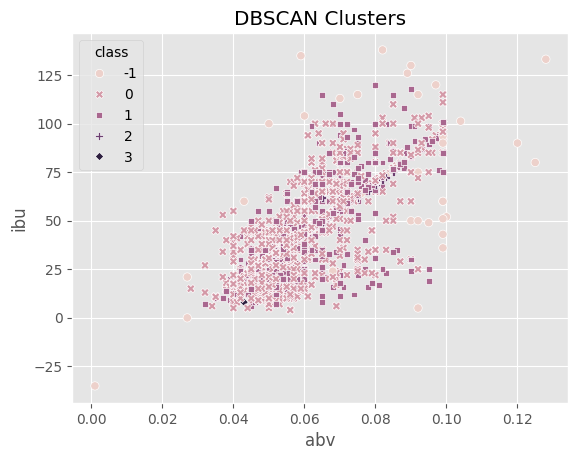

In [79]:
sns.scatterplot(data=X_cl_vis, x='abv', y='ibu', hue='class', style='class')
plt.title('DBSCAN Clusters')
plt.show()

✅Let's see on sample silhouette.

In [80]:
metrics.silhouette_score(X_cl_train, best_clusters.labels_)

0.36972138526981435

Well, it was excpected.

✅See also on beer in our clasters.

In [87]:
for cl in np.unique(best_clusters.labels_):
    print(f"Class label: {cl}")
    print(f"Average IBU: {X_cl_vis[X_cl_vis['class'] == cl]['ibu'].mean()}")
    print(f"Average ABV: {X_cl_vis[X_cl_vis['class'] == cl]['abv'].mean()}")
    print("Unique styles(5 random): ")
    print(" ; ".join(np.random.choice(X_cl_vis[X_cl_vis['class'] == cl]['style'].unique(), size=5)))

Class label: -1
Average IBU: 67.84362560199118
Average ABV: 0.07754166666666666
Unique styles(5 random): 
American Double / Imperial Stout ; American Brown Ale ; American IPA ; American Double / Imperial Stout ; American Wild Ale
Class label: 0
Average IBU: 40.39696491726298
Average ABV: 0.05775214805023132
Unique styles(5 random): 
Belgian Strong Dark Ale ; American Porter ; Shandy ; English Pale Mild Ale ; Munich Dunkel Lager
Class label: 1
Average IBU: 45.400877149577965
Average ABV: 0.06204945717732207
Unique styles(5 random): 
Pumpkin Ale ; Rauchbier ; American Strong Ale ; Extra Special / Strong Bitter (ESB) ; American Double / Imperial Pilsner
Class label: 2
Average IBU: 63.961102816893636
Average ABV: 0.07572727272727273
Unique styles(5 random): 
Saison / Farmhouse Ale ; Saison / Farmhouse Ale ; Fruit / Vegetable Beer ; American IPA ; Rye Beer
Class label: 3
Average IBU: 24.525762153885722
Average ABV: 0.04966666666666666
Unique styles(5 random): 
Hefeweizen ; Berliner Weissbie

✅It is difficult to say anything about beer in the presented data, since the clusters obtained are very similar in nature. The conclusion is that clustering did not do a very good job of identifying the similarities of beer varieties. Perhaps the reason is a lack of features.